<a href="https://colab.research.google.com/github/xunxunshi/Recurrent-Network-for-Stock-Predictions/blob/main/Recurrent_Network_for_Stock_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The project aims to use recurrent network to predict for future stock prices (next 10 days). 

*   The recurrent network was trained on 24 different stocks in the DOW Index, validates on 2 stocks (implemented to monitors the early stop loss) ,and tests the performance of 2 stocks. 
*   The recurrent network was also trained on over 2000 days and used to predict the stock price of the next ten days 
*   The input feature  is : 
    - Volume of the stock at time (t)
    - Closing Price of the stock at time (t)
*   The output feature: 
    - Closing price of the stock from time (t) to time (t+10)
* Hypothesis : 
  - Man features can contributes to the movement of stock price (such as fundamentals data, market sector, news semantics,mangement change, politics, economy indicators, etc). 
  - However, given that DOW stocks share similar market cap, I hypothesize that there are underlying common trends between a stock's historical price/volume and the next 10 day prices that a ML algorithm can learn. 
  - This hypothesis is driven by the intuition that many investors trade stocks based on "Technical Indicators" ( such as RSI, MA, etc), which is based on the stock's price and volume. The reaction to the stock's historical price and volume should be projected in the future stock price, and is what the recurrent network aims to learn. 

* Future Work : 
  - In the future, I will incorporate additional features including fundamentals data, market sector, and economy indicators to improve data. 






In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install yahoo_fin
import yahoo_fin.stock_info as si
hide_toggle()


In [3]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt 
import numpy as np

In [4]:
import tensorflow as tf 
import keras.backend as K
from tensorflow import keras as ks 
from tensorflow import keras as ks 
from scipy import stats
import numpy as np 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import losses,metrics ,activations 
from keras.callbacks import EarlyStopping

In [5]:
import datetime
from datetime import datetime,timedelta
today=datetime.date(datetime.now())+timedelta(days=1) 

## this function returns the scrapped stock information in the specifie date using the yahoo finance package 
def returnHistory(stockName,inter,start,end,prepost='false'):
    stock_df= yf.Ticker(stockName).history(interval=inter,start=start,end=end,prepost=prepost)
    return stock_df

In [6]:
DOW_tickers=si.tickers_dow() ## retrieving all DOW stock tickers 

In [7]:
from datetime import date


The following code scapes 27 stocks in DOW for over 2000 days of data data ( from 2013/1/1 to today) . 

The data is aggregated into a 3D numpy series with the following dimensions : [batches, timesteps, features ].  

*   Batches : include various stocks 
*   Timesteps: total number of business days between 2013/1/1 and today
*   Features: Closing Price and Volume 







In [9]:
stock_daily=np.expand_dims(np.array(returnHistory(DOW_tickers[0],'1d','2013-01-01',today)[['Close','Volume']].values),axis=0) ## take the first instance of the stock
Days=abs(int((date(2013, 1, 1)-today).days)*(4.5/7)) ## estimate number of days between specified time frame. Since there are only 5 operating business day per week and there are also holidays, we estimate the days as  4.5/7*[Date_specified-today] to set as the minimum number of data points 

for tickers in DOW_tickers[1:]: ## loop through the list of Dow stocks 
  stock_daily_temp= np.expand_dims(np.array(returnHistory(tickers,'1d','2013-01-01',today)[['Close','Volume']].values),axis=0)## grab the next ticker information 
  if(len(stock_daily_temp[0])>Days):
    stock_daily= np.concatenate((stock_daily, stock_daily_temp)) ## add it as another instance of data on the numpy array 

Stocks in the test set: 

In [283]:
DOW_tickers[-2:]

['WBA', 'WMT']

In [11]:
stock_daily.shape
#instances, timesteps, features]

(29, 2087, 2)

In [275]:
X_train,Y_train=stock_daily[0:25,:len(stock_daily[0])-10],stock_daily[0:25, -10:,0]
X_valid,Y_valid=stock_daily[25:27,:len(stock_daily[0])-10],stock_daily[25:27, -10:,0]
X_test,Y_test=stock_daily[27:,:len(stock_daily[0])-10],stock_daily[27:, -10:,0]

##### Applying the min max scaler : 
1.    Shape the data back into a 2D array for applying the min max scaler 
2.    Apply the min/max scaler based on min/max stock value across all instance and across all stock price ( Another method is to scale each stock proprotionally to the min/max of itself) 
3.  Rescale back to 3D array but with this : batch, time, features

 

In [276]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
 
instancesNum, timestepsNum, featuresXNum = X_train.shape
X_train = np.reshape(X_train, (-1, featuresXNum ))
X_train = scaler.fit_transform(X_train)
X_train=np.reshape(X_train,(instancesNum,timestepsNum,featuresXNum))

instancesNum_Val, timestepsNum_Val, featuresXNum_Val = X_valid.shape
X_valid = np.reshape(X_valid, (-1, featuresXNum_Val))
X_valid = scaler.transform(X_valid)
X_valid=np.reshape(X_valid,(instancesNum_Val,timestepsNum_Val,featuresXNum_Val)) 

instancesNum_Test, timestepsNum_Test, featuresXNum_Test = X_test.shape
X_test = np.reshape(X_test, (-1, featuresXNum_Test))
X_test = scaler.transform(X_test)
X_test=np.reshape(X_test, (instancesNum_Test, timestepsNum_Test, featuresXNum_Test)) 

Y_trainshape=Y_train.shape
Y_train = scaler.fit_transform(np.reshape(Y_train, (-1, 1))) ## separate scaler for the y values 
Y_train =np.reshape(Y_train,(Y_trainshape))

Y_validshape=Y_valid.shape
Y_valid = scaler.transform (np.reshape(Y_valid, (-1, 1)))
Y_valid =np.reshape(Y_valid,(Y_validshape))
## note that we do not need to transform y_test, this data is not used during training 
## however, we do need to inverse transform y_pred in the future 

 ### Implementing a deep RNN to predict the trend of next 10 data points 

In [187]:
model=ks.models.Sequential([
                               ks.layers.SimpleRNN(20,return_sequences=True, input_shape=[None,2]),
                               ks.layers.SimpleRNN(100,return_sequences=True),
                               ks.layers.SimpleRNN(100,return_sequences=True),
                               ks.layers.SimpleRNN(100), 
                               ks.layers.Dense(10)])

In [197]:

model.compile(optimizer='adam',loss=tf.keras.losses.Huber(delta=1.5))

es = EarlyStopping(monitor='val_loss', mode='min', patience=50)

model.fit(X_train ,Y_train,epochs=1000,validation_data=(X_valid, Y_valid),callbacks=[es])



Epoch 1/1000
1/1 [==============================] - 6s 6s/step - loss: 1.3149e-04 - val_loss: 0.3513
Epoch 2/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3896 - val_loss: 0.0243
Epoch 3/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0296 - val_loss: 0.0800
Epoch 4/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0617 - val_loss: 0.1405
Epoch 5/1000
1/1 [==============================] - 3s 3s/step - loss: 0.1069 - val_loss: 0.1110
Epoch 6/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0783 - val_loss: 0.0631
Epoch 7/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0404 - val_loss: 0.0326
Epoch 8/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0238 - val_loss: 0.0237
Epoch 9/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0280 - val_loss: 0.0254
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 0.0381 - val_loss: 0.0269
Epoch 11/1000
1/1 [======

In [277]:
 TestStocks=model.predict(X_test)

In [278]:
X_test,Y_test=stock_daily[27:,:len(stock_daily[0])-10],stock_daily[27:, -10:,0]

###The trained network is used to predict the next ten days of stock price from the test set. 

For both stocks of the test set, the predicted stock price are lower than the actual stock price, but they follows similar trends between the day n to n+10. 

To a degree, the 10 day prediction trend was similar to the actual trend in both stocks.  

However, there is a sharp drop in the predicted stock price on day t+1, which is suprising.  This sudden drop in stock price could be because the overall DOW stocks dropped during those times that affected prediction, and if these trends also carried out in the validation data then this may contribute to some overfitting of trends. 

As a whole, 25 instances (stocks) with two input features may not be enough to generalize the stock trends. This experiment can be replicated again with higher batches and additional features. 

Text(0.5, 1.0, 'Test data: WBA')

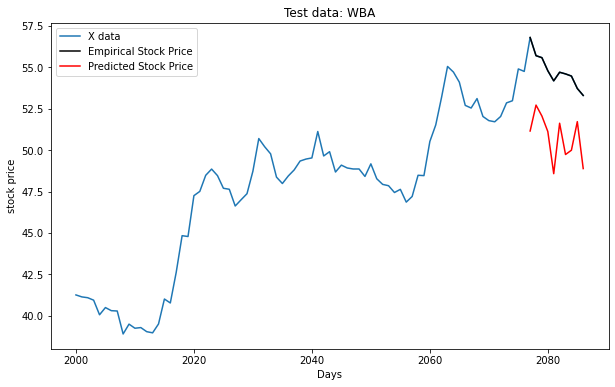

In [288]:
plt.figure(figsize=(10,6))
plt.ylabel('stock price')
plt.xlabel('Days')

plt.plot(np.arange(2000,2000+10+len(X_test[0,2000:,0])),stock_daily[27:,2000:,0][0],label='X data')

plt.plot(np.arange(2000+len(X_test[0,2000:,0]),2000+len(X_test[0,2000:,0])+10),Y_test[0],color='black',label='Empirical Stock Price')
plt.plot(np.arange(2000+len(X_test[0,2000:,0]),2000+len(X_test[0,2000:,0])+10),scaler.inverse_transform(TestStocks)[0],color='red',label='Predicted Stock Price') 
plt.legend()
plt.title('Test data: '+str(DOW_tickers[-2:][0]))

Text(0.5, 1.0, 'Test data: WMT')

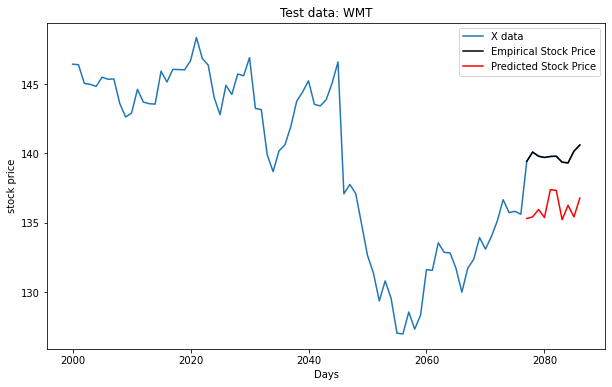

In [287]:
plt.figure(figsize=(10,6))
plt.ylabel('stock price')
plt.xlabel('Days')

plt.plot(np.arange(2000,2000+10+len(X_test[0,2000:,0])),stock_daily[27:,2000:,0][1],label='X data')

plt.plot(np.arange(2000+len(X_test[0,2000:,0]),2000+len(X_test[0,2000:,0])+10),Y_test[1],color='black',label='Empirical Stock Price')
plt.plot(np.arange(2000+len(X_test[0,2000:,0]),2000+len(X_test[0,2000:,0])+10),scaler.inverse_transform(TestStocks)[1],color='red',label='Predicted Stock Price') 
plt.legend()
plt.title('Test data: '+str(DOW_tickers[-2:][1]))

## Future work: 
- Retrain the RNN with more instances from similar sectors such as from NASDAQ 
- Additional Features :
  - Average market performance (such as historical index fund prices) 
  - Balance sheet data (Asset, Liabilities,etc) and Income statment data ( Earnings, P/E, etc) 
  - Sector Data ( categorical ) 




In [1]:
 ### The following codes is not mine (taken from stackoverflow). This code hides outputs of certain cells and is implemented to shorten the lenght of the  notebook.

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'


    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)